# Project 3- Understanding User Behavior

Author: Isabel Garcia Pietri

## Summary

The objective of this project is to prepare the infrastructure to capture the events generated by the users of a hypothetical mobile game.

Parts of the pipeline:

- Our users interact with the mobile app.

- An app server handles user requests and log events to Kafka.

- Spark pulls events from Kafka, transforms them and writes them to HDFS. 

- Once the data is available in HDFS, perform queries using Presto.

The image below represents a simplified diagram of the pipeline.


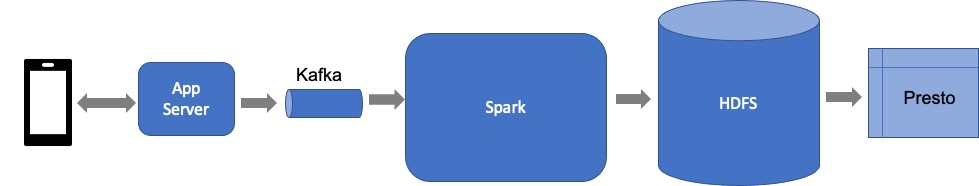

## Containers configuration

To spin up the pipeline we use **six** Docker containers:

- A docker container (**MIDS** container) to run the web application, to generate a stream of events simulating our users interacting with our mobile game, and to watch the messages arriving to kafka. 
- A **Kakfa** docker container. Kafka is an open-source stream-processing software platform. In our pipeline, kafka is in charge of the streaming process: catch the events and manage them for Spark to consume them.
- A **Zookeeper** docker container. Zookeeper is an open-source centralized service that manages kafka brokers, partitions, send notifications to kafka when topics are created/deleted, etc. 
- A **Spark** docker container. Spark is an open-source distributed processing system used for big data workloads. In our pipeline, we use Spark to process the data and put it in queriable dataframes.
- A claudera docker container (distribution of **hadoop**). The Hadoop Distributed File System (HDFS) is an open-source distributed file system. In our pipeline, we save our final dataframes in HDFS.
- A **Presto** docker container. Presto is an open source, distributed SQL query engine designed for fast, interactive queries on data in HDFS. In our pipeline, we use Presto to make queries in the dataframes saved in HDFS.

To spin up the docker containers we use a docker-compose file (`docker-compose.yml`). This docker-compose file has a similar configuration as the one used in class. This configuration is represented in the figure below.

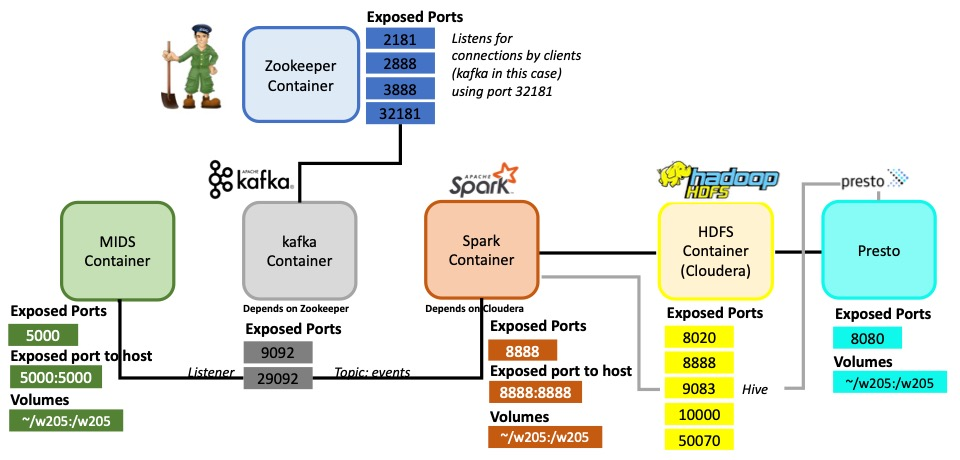

## Web app

To build the web app we used the Python library Flask. Flask is a web framework, that provides tools, libraries and technologies that allow to build a web application. This web app supports various types of user events: 

- Default response
- Purchase a sword (gold/katana)
- Join a guild (warriors/crusaders) 
- Purchase a crossbow (small/medium)
- Purchase a buckler shield

Below is the code of the web app. The code logic is explained in the comments. The name of the file that contains this code is `game_api.py`.

```python
#!/usr/bin/env python
import json
from kafka import KafkaProducer
from flask import Flask, request

# Create an instance of the Flask class
app = Flask(__name__)

# Initialize a new Kafka producer
# Set the host and port the producer should contact: Kafka container port 29092
producer = KafkaProducer(bootstrap_servers='kafka:29092')

# Define functions to handle events

# Define a function to send the events to kafka
def log_to_kafka(topic, event):
    # Add http header fields information to the events to have more information about users
    event.update(request.headers)
    # Send encoded events to kafka
    # The json.dumps() method encodes the event into JSON formatted String.
    producer.send(topic, json.dumps(event).encode())

# Define a function to handle the default response
# The route() decorator tells Flask what URL should trigger the function
# The function creates a "key" : "value" pair to define the type of the event
# The function calls the Kafka producer (using the log_to_kafka function) and sends the encoded event to the kafka topic `events`
# The function returns a message to the user
@app.route("/")
def default_response():
    default_event = {'event_type': 'default'}
    log_to_kafka('events', default_event)
    return "This is the default response!\n"

# Define functions to handle the user action of purchasing a sword. Two types of swords are supported: gold and katana
# The route() decorator tells Flask what URL should trigger the function
# The function creates two "key" : "value" pairs to define the type of the event and the type of sword
# The function calls the Kafka producer (using the log_to_kafka function) and sends the encoded event to the kafka topic `events`
# The function returns a message to the user
@app.route("/purchase_a_gold_sword")
def purchase_a_gold_sword():
    purchase_gold_sword_event = {'event_type': 'purchase_sword', 'type': 'gold' }
    log_to_kafka('events', purchase_gold_sword_event)
    return "Gold sword Purchased!\n"

@app.route("/purchase_a_katana_sword")
def purchase_a_katana_sword():
    purchase_katana_sword_event = {'event_type': 'purchase_sword', 'type': 'katana' }
    log_to_kafka('events', purchase_katana_sword_event)
    return "Katana sword Purchased!\n"

# Define functions to handle the user action of joining a guild. Two guilds are available: warriors and crusaders 
# The route() decorator tells Flask what URL should trigger the function
# The function creates two "key" : "value" pairs to define the type of the event and the name of the guild
# The function calls the Kafka producer (using the log_to_kafka function) and sends the encoded event to the kafka topic `events`
# The function returns a message to the user
@app.route("/join_warriors_guild")
def join_warriors_guild():
    join_warriors_guild_event = {'event_type': 'join_guild', 'name': 'warriors' }
    log_to_kafka('events', join_warriors_guild_event)
    return "Joined Warriors Guild!\n"

@app.route("/join_crusaders_guild")
def join_crusaders_guild():
    join_crusaders_guild_event = {'event_type': 'join_guild', 'name': 'crusaders' }
    log_to_kafka('events', join_crusaders_guild_event)
    return "Joined Crusaders Guild!\n"

# Define functions to handle the user action of purchasing a crossbow. Two crossbows are available: small and medium
# The route() decorator tells Flask what URL should trigger the function
# The function creates two "key" : "value" pairs to define the type of the event and the type of crossbow
# The function calls the Kafka producer (using the log_to_kafka function) and sends the encoded event to the kafka topic `events`
# The function returns a message to the user
@app.route("/purchase_a_small_crossbow")
def purchase_a_small_crossbow():
    purchase_small_crossbow_event = {'event_type': 'purchase_crossbow', 'type': 'small' }
    log_to_kafka('events', purchase_small_crossbow_event)
    return "Small Crossbow Purchased!\n"

@app.route("/purchase_a_medium_crossbow")
def purchase_a_medium_crossbow():
    purchase_medium_crossbow_event = {'event_type': 'purchase_crossbow', 'type': 'medium' }
    log_to_kafka('events', purchase_medium_crossbow_event)
    return "Medium Crossbow Purchased!\n"

# Define a function to handle the user action of purchasing a shield. Only one type of shield is available: buckler shield
# The route() decorator tells Flask what URL should trigger the function
# The function creates two "key" : "value" pairs to define the type of the event and the type of shield
# The function calls the Kafka producer (using the log_to_kafka function) and sends the encoded event to the kafka topic `events`
# The function returns a message to the user
@app.route("/purchase_a_shield")
def purchase_a_shield():
    purchase_shield_event = {'event_type': 'purchase_shield', 'type': 'buckler'}
    log_to_kafka('events', purchase_shield_event)
    return "Shield Purchased!\n"
```

### Run the app

In a terminal, we run the web app using the command below.

```
docker-compose exec mids env FLASK_APP=/w205/project-3-ipietri/game_api.py flask run --host 0.0.0.0
```

- Run the app in the `mids` container.
- Define the environment variable to run the application. This basically defines the location of the application (`env FLASK_APP=/w205/project-3-ipietri/game_api.py`) 
- Run the server (`flask run`).
- `--host=0.0.0.0` makes the server publicly available (listen on all public IPs).


## Configure Kafka

Create a topic in Kafka to receive the events created by the users. The name of the topic is `events`.

```
docker-compose exec kafka kafka-topics --create --topic events --partitions 1 --replication-factor 1 --if-not-exists --zookeeper zookeeper:32181
```

- Run `kafka-topics` in the `kafka` container. `kafka-topics` is a tool used to create, alter, list, and describe topics.
- `--create --topic events` is to request the creation of a topic called `events`. 
- `--partitions 1 --replication-factor 1` defines only one partition in the topic and a replication factor of one.
- `--if-not-exists` only creates the topic if it does not exist.
- `--zookeeper zookeeper:32181` notifies zookeeper about the creation of the topic using the port 32181, which is the port that zookeeper uses to communicate with kafka.



Watch the data coming into the topic `events`.

```
docker-compose exec mids kafkacat -C -b kafka:29092 -t events -o beginning
```

- Run `kafkacat` in the `mids` container in consumer mode (`-C`).
- The messages are consumed from the broker (`-b`) located in the host and port pair `kafka:29092` (kafka container and listener port).
- The messages are read from the `events` topic (`-t events`).
- All messages available in the topic are consumed as they arrive (`-o beginning`).


## Configure Spark jobs

For business purposes, we decided to store the events related with weapon purchases in a table, and the events related with users joining a guild in another table. This configuration makes easy to analyze purchase data using a single table (e.g., check what kind of weapons are more popular among our users to inform the game development team).

We use two scripts to set up the data processing in Spark:

- `spark_weapon_purchases.py`: handles the events related with weapon purchases (swords, crossbows and shields).

- `spark_join_guild.py`: handles the join guild events.

To run these scripts, we use two separate terminals and run the commands below (one per terminal) to submit (`spark-submit`) the jobs in the `spark` container.

```
docker-compose exec spark spark-submit /w205/project-3-ipietri/spark_weapon_purchases.py
```

```
docker-compose exec spark spark-submit /w205/project-3-ipietri/spark_join_guild.py
```

The code in both scripts is very similar. The description below shows one of the scripts as an example, but the description is applicable to the functions in both scripts.

- Function that defines the **schema of the events**. `StructType` objects define the schema of Spark DataFrames. `StructType` objects contain a list of `StructField` objects that define the name, type, and nullable flag for each column in a DataFrame.

```python
def purchase_weapon_event_schema():
    """
    root
    |-- Accept: string (nullable = true)
    |-- Host: string (nullable = true)
    |-- User-Agent: string (nullable = true)
    |-- event_type: string (nullable = true)
    |-- type: string (nullable = true)
    """
    return StructType([
        StructField("Accept", StringType(), True),
        StructField("Host", StringType(), True),
        StructField("User-Agent", StringType(), True),
        StructField("event_type", StringType(), True),
        StructField("type", StringType(), True),
    ])
```

- Function to **filter events** of a certain type. The `json.loads` method takes the event as a json string and returns a python dictionary. Then the function returns True if the event is of a certain type (in the example below returns True if the event is a purchase of a sword, a purchase of a crossbow or a purchase of a shield).

```python
@udf('boolean')
def is_weapon_purchase(event_as_json):
    """udf for filtering events
    """
    event = json.loads(event_as_json)
    if (event['event_type'] == 'purchase_sword') or (event['event_type'] == 'purchase_crossbow') \
    or (event['event_type'] == 'purchase_shield'):
        return True
    return False
```

- A **main** function to create the `SparkSession`, load the events and create a DataFrame, filter events, register the table in Hive and start the streaming process.

    - Create a `SparkSession`.
    
    `SparkSession` is the entry point to Spark SQL. `SparkSession.builder` creates a `SparkSession`. 
    
    `appName` gives an optional name.
    
    `enableHiveSupport` enables Hive support, that allows running structured queries on Hive tables and a persistent Hive metastore.
    
    `getOrCreate` gets the current SparkSession or creates a new one.
    
    Once created, `SparkSession` allows for creating a DataFrame, creating a Dataset, accessing the Spark SQL services, executing a SQL query, loading a table and accessing DataFrameReader interface.
    
    - Load events.
    
    `readStream` returns a new `DataStreamReader`. `DataStreamReader` is the interface to describe how data is loaded to a streaming Dataset from a streaming source.
    
    `format` Specifies the input data source format. In this case `kafka`.
    
    `options` adds an input option for the underlying data source. In this case the kafka server (host and port pair `kafka:29092`) and the name of the topic in kafka (`events`)
    
    `load` Loads input in as a DataFrame.
    
    - Filter and cast values to strings. 
    
    Create a DataFrame filtering events of a certain type (using the function to filter events).
    
    Select columns, cast to strings and apply the schema to the events (using the schema function). 
    
    One of the columns stores the raw events as strings.
    
    - Register the table in hive.
    
    Drop the table if already exists. The `drop table if exists` SQL statement enables a check to see if the table exists prior to attempting the dropping (deletion) of the table. If the table does not exist then the `DROP TABLE` statement is not executed so no error occurs. 
    
    Create an external table with `create external table if not exists`. A Hive external table allows you to access external HDFS file as a regular managed tables. 
    
    - Once the final DataFrame is defined, all that is left is start the streaming computation. To do that, we use the DataStreamWriter returned through `DataFrame.writeStream()`. We specify the format (`parquet`), output location, checkpoint location (location where the system will write all the checkpoint information) and trigger interval.
    
    - `awaitTermination`. Continue streaming until the user emits a termination signal. When it receives signal from user (i.e. CTRL+C) then streaming will be stopped.


```python
def main():
    """main
    """
    spark = SparkSession \
        .builder \
        .appName("ExtractEventsJob") \
        .enableHiveSupport() \
        .getOrCreate()

    raw_events = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", "kafka:29092") \
        .option("subscribe", "events") \
        .load()

    weapon_purchases = raw_events \
        .filter(is_weapon_purchase(raw_events.value.cast('string'))) \
        .select(raw_events.value.cast('string').alias('raw_event'),
                raw_events.timestamp.cast('string'),
                from_json(raw_events.value.cast('string'),
                          purchase_weapon_event_schema()).alias('json')) \
        .select('raw_event', 'timestamp', 'json.*')

    spark.sql("drop table if exists weapon_purchases")
    sql_string = """
        create external table if not exists weapon_purchases (
            raw_event string,
            timestamp string,
            Accept string,
            Host string,
            `User-Agent` string,
            event_type string,
            type string
            )
            stored as parquet
            location '/tmp/weapon_purchases'
            tblproperties ("parquet.compress"="SNAPPY")
            """
    spark.sql(sql_string)

    sink = weapon_purchases \
        .writeStream \
        .format("parquet") \
        .option("checkpointLocation", "/tmp/checkpoints_for_weapon_purchases") \
        .option("path", "/tmp/weapon_purchases") \
        .trigger(processingTime="10 seconds") \
        .start()

    sink.awaitTermination()
```

## Create a stream of events

To simulate events triggered when users interact with our mobile app we use ApacheBench. ApacheBench is a computer program for measuring the performance of HTTP web servers. It is primarily used to test web servers.

We created a script (`ab-stream.sh`) that generates users events every second. We generate random usernames (e.g., user12345.att.com) with different domains (.att.com, .comcast.com, .spectrum.com, .xfinity.com), and create random events selected from the events supported by our system (default, purchase a gold sword, purchase a katana sword, join warriors guild, join crusaders guild, purchase a small crossbow, purchase a medium crossbow and purchase a shield).

Script code:

```bash
#!/bin/bash

# Declare an array of possible host domains
declare -a arr=(".att.com" ".comcast.com" ".spectrum.com" ".xfinity.com")

# Declare an array with possible user actions
declare -a arr2=("http://localhost:5000/" "http://localhost:5000/purchase_a_gold_sword" \
"http://localhost:5000/purchase_a_katana_sword" \
"http://localhost:5000/join_warriors_guild" "http://localhost:5000/join_crusaders_guild" \
"http://localhost:5000/purchase_a_small_crossbow" "http://localhost:5000/purchase_a_medium_crossbow" \
"http://localhost:5000/purchase_a_shield" )

# Loop to create events
while true; do
# Generate random host names
randomhost="Host: user"
ranNum=${RANDOM:0:100000}
randomhost+="$ranNum"
rand=$[ $RANDOM % 4 ]
domain=${arr[$rand]}
randomhost+="$domain" 

# Randomly select a possible event
rand2=$[ $RANDOM % 8 ]
event=${arr2[$rand2]}

# Create random events using random hosts and events from above
docker-compose exec mids ab -n 1 -H "$randomhost" $event

# Pauses the execution of the next command for 1 second
sleep 1

done
```



To run the script, open a terminal and use the command below:
```
bash ab-stream.sh
```

## Check data in Hadoop

We can check that the data is saved in HDFS using the commands below. We have two directories, one for the table that contains weapon purchases and another one for the table that contains the join a guild events.

```
docker-compose exec cloudera hadoop fs -ls /tmp/weapon_purchases
docker-compose exec cloudera hadoop fs -ls /tmp/join_guild
```

- Execute `hadoop fs` in the `claudera` docker container. This runs a generic filesystem user client (runs the hadoop file system shell).
- List the files (`-ls`) in the `/tmp/weapon_purchases` and `/tmp/join_guild` directories.

## Query data using Presto

Once the data is available in HDFS we use Presto to make queries and answer business questions.

```
docker-compose exec presto presto --server presto:8080 --catalog hive --schema default
```

- Execute `presto` in the `presto` container.
- `--server presto:8080`. Define the server hostname:port_number. In this case, `presto` container and port `8080`.
- Connect to hive `--catalog hive` and use the default schema `--schema default`.

Some examples of queries are shown below.


**Check available tables**
```
show tables;
```

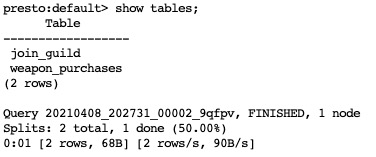

**Describe tables**

```
describe weapon_purchases;
```

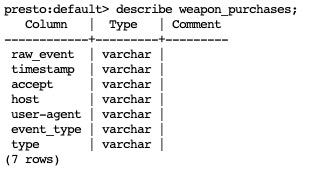

```
describe join_guild;
```

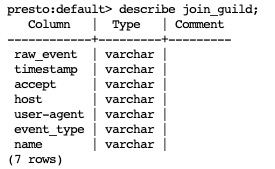

**Visualize some columns of the `weapon_purchases` table**

```sql
select timestamp, host, event_type, type from weapon_purchases;
```

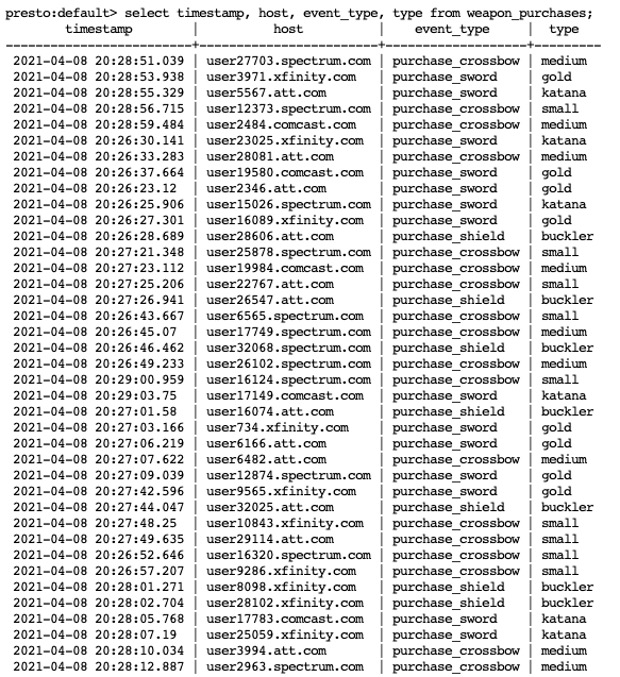

**Visualize some columns of the `join_guild` table**

```sql
select timestamp, host, event_type, name from join_guild;
```

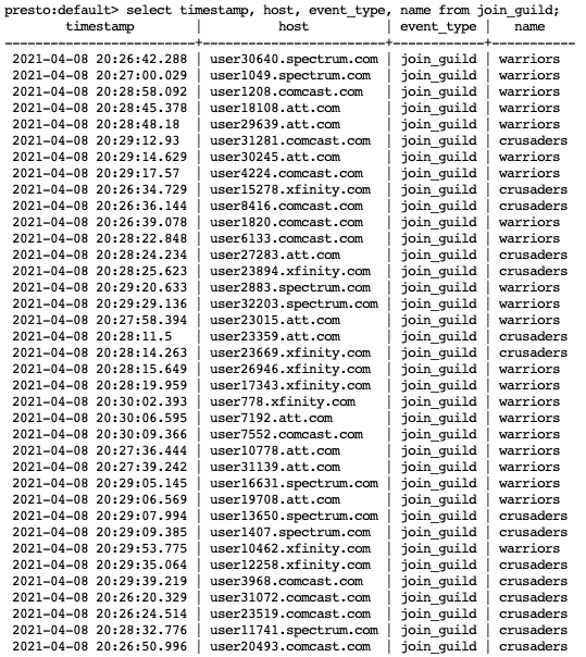

**Get how many purchases of each weapon have been placed so far**

```sql
select event_type, count(event_type) as totals from weapon_purchases group by event_type;
```

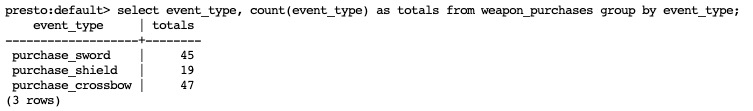

**Get how many purchases of each type of sword have been placed so far**
```sql
select event_type, type, count(event_type) as totals from weapon_purchases 
where event_type='purchase_sword' group by event_type, type;
```

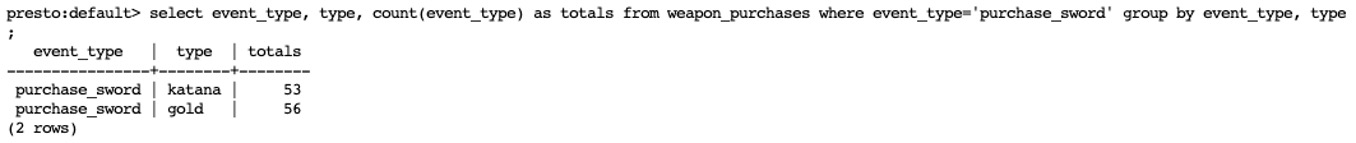

**Get how many users have joined a guild so far**

```sql
select count(event_type) as totals from join_guild;
```

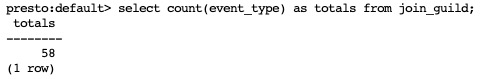

**Get how many users have joined each guild**

```sql
select event_type, name, count(event_type) as totals from join_guild group by event_type, name;
```

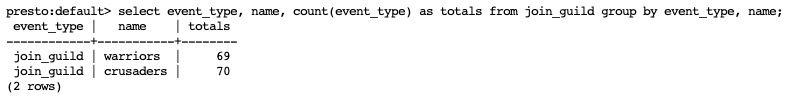